# Project 3: Reddit API NLP Classification

## Problem Statement

Being part of the Nintendo Marketing Team of nintendo switch, I am interested in finding out what popular topics and keyword jargons belong to the fields of Mario and Legend of Zelda. Conducting analysis on Reddit posts will allow me to craft online content and advertisements to better target people interested in casual, adventure, platformer video games.

The main objective of this project is to scrape two subreddits: `r/Mario` and `r/Zelda` using Reddit's API. The scraped data from the two subreddits will then be passed through various classification models, `CountVectorizer`/`TfidVectorizer` with `Naive Bayes Classifier` and `LogisticRegression` that will assign each observation to the most likely class of subreddit. The models should help the data science marketing team of my company identify what makes the respective subreddit posts unique from one another.

In this process, the subreddit posts will undergo preprocessing and EDA. The success of the models that we decide on will be determined through the highest accuracy based on the scores obtained.

## Executive Summary

Natural Language Processing, or NLP for short, involves using specialized machine learning techniques to make predictions about the text in a body of documents, including things like authorship attribution, sentiment analysis, text generation, and in some cases the appearance of something resembling semantic understanding.

Nintendo Switch, a hybrid home console and handheld device is one of highest revenue generator of Nintendo, it had outsold the lifetime sales of Wii U, its home console predecessor.Mario Kart 8 Deluxe is the best-selling game on the platform at over 46 million copies sold The Mario franchise alone has sold 167.11 million copies on the Nintendo Switch, which is the most the franchise has ever sold on a single platform. The Legend of Zelda has also sold the most on a single platform with the Nintendo Switch with 41.13 million copies. 

In this project, I would like to further explore the key similarities and differences between Data Science and Software Engineering in terms of the current discussions and topics that people are discussing on Reddit. Reddit, in recent times, have become a popular avenue for people all over the world to ask one another about different career prospects and experiences. As such, scraping Subreddit Posts gives us an interesting source of data that we can analyze to understand what are the popular topics in these respective career fields.

The web scraping portion of this project is covered in another notebook. In this notebook, I will be covering the steps taken to clean and analyze the data collected, as well as further steps taken to pre-process the text data, visualize the data, use different models to find the optimal model and analyze misclassified posts.

## Contents:
- [Data Collection](#Data-Collection) (In notebook "Data_Collection_Reddit.ipynb")
- [Explanatory Data Analysis](#Explanatory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Pre-Processing](#Pre-Processing)
- [Data Visualization](#Data-Visualization)
- [Modelling](#Modelling)
- [Evaluation](#Evaluation)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)

### Importing Packages

In [1]:
# Import libraries
import requests
import time
import nltk
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # NLP classification
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

from wordcloud import WordCloud

I have outlined my process of scraping data in the other Jupyter Notebook in this project folder. In this notebook, I will be reading in the csv files that contain my scrapped data for both the mario and zelda subreddit posts.

### Read in CSV

In [2]:
mario = pd.read_csv("mario_reddit_posts.csv")
mario.sample(5)

,subreddit,title,clicked,ups,downs,post_paragraph,likes,number_of_comments,category,score,author_flair_css_class,subreddit_type
1297,Mario,Mario’s movie render reminds me of the first i...,False,10,0,NaN,NaN,0,NaN,10,NaN,public
434,Mario,A thought: maybe Mario's voice woulda been mor...,False,59,0,NaN,NaN,3,NaN,59,NaN,public
1131,Mario,Hear me out,False,87,0,NaN,NaN,27,NaN,87,NaN,public
2048,Mario,It’s a vicious cycle,False,110,0,NaN,NaN,3,NaN,110,zPeach,public
1680,Mario,I just know Bowser will be amazing in this movie.,False,308,0,NaN,NaN,13,NaN,308,NaN,public


In [3]:
zelda = pd.read_csv("zelda_reddit_posts.csv")
zelda.sample(5)

,subreddit,title,clicked,ups,downs,post_paragraph,likes,number_of_comments,category,score,author_flair_css_class,subreddit_type
640,zelda,[MM] Found an old ad campaign for Majora's Mas...,False,12,0,NaN,NaN,3,NaN,12,gerudo,public
552,zelda,[OC] Painted this wee fella this afternoon. Wh...,False,146,0,NaN,NaN,9,NaN,146,NaN,public
50,zelda,[OC][BOTW] Princess Zelda with Pauldrons,False,116,0,NaN,NaN,3,NaN,116,hylian,public
453,zelda,[TP] Finally received my F4F True Form Midna f...,False,181,0,NaN,NaN,10,NaN,181,NaN,public
1144,zelda,r/Zelda Meta Discussion - Rule 2: Mark Spoilers,False,3,0,"Hi r/Zelda,\n\nTo continue discussing the subr...",NaN,4,NaN,3,rito,public


In [4]:
print(mario.shape)
print(zelda.shape)

(2258, 12)
(2454, 12)


In [5]:
# Import combinded df
df = pd.read_csv("./master_df.csv")
df.sample(5)

,subreddit,title,ups,post_paragraph,number_of_comments,score,author_flair_css_class,target
259,Mario,Peach's Castle-ship?,13,Does this look like a spaceship to anyone else...,5,13,NaN,1
1957,Mario,Make the comments Mario’s search history,191,NaN,191,191,zLuigi,1
4626,zelda,[TP] An unexpected ally (Twilight Princess Vol...,32,NaN,5,32,NaN,0
2943,zelda,[OoT] This Komi San fan art.,282,NaN,14,282,NaN,0
2442,zelda,[OoT] Playing it for first time and with Citra...,836,NaN,103,836,NaN,0


In [6]:
print(df.shape)

(4710, 8)


### Explanatory Data Analysis

In [7]:
# Creating a new column to count the len of string
df['string_count'] = df['title'].apply(len)

# Creating a new column to count the number of words
df['word_count'] = df['title'].map(lambda row: len(row.split()))

df.head()

,subreddit,title,ups,post_paragraph,number_of_comments,score,author_flair_css_class,target,string_count,word_count
0,Mario,Super Mario Movie Trailer MEGATHREAD,374,Want to discuss about the movie trailer? You'r...,894,374,NaN,1,36,5
1,Mario,"Karma farming posts get removed, egregious rep...",113,"First up, apologies for these out of date rule...",7,113,NaN,1,74,12
2,Mario,"If there are power ups in the movie, how do yo...",425,NaN,59,425,NaN,1,185,38
3,Mario,I'm still thinking about the Mario Movie so I ...,696,NaN,29,696,NaN,1,97,20
4,Mario,I understand the disappointment of Charles Mar...,381,NaN,94,381,NaN,1,163,27


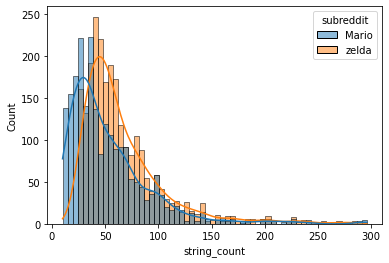

In [8]:
sns.histplot(df, x= "string_count", hue = "subreddit", kde = True);

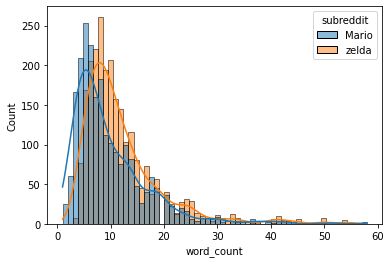

In [9]:
sns.histplot(df, x= "word_count", hue = "subreddit", kde = True);

In [10]:
# Overview of Numerical Columns
df.groupby("subreddit").mean()

,ups,number_of_comments,score,target,string_count,word_count
subreddit,,,,,,
Mario,116.519043,15.852081,116.519043,1.0,53.161205,9.830381
zelda,587.442496,27.479201,587.442496,0.0,66.612969,12.068108


There is a clear difference of score between the reddits. Mario has less active communities on Reddit with 113k members to Zelda of 2.1m members.

### Sentiment Analysis for each reddit

In [11]:
sent = SentimentIntensityAnalyzer()

In [12]:
df['sentiment'] = df['title'].apply(sent.polarity_scores)
df["compound_score"] = [df['sentiment'][i].get('compound') for i in  range(len(df))]

In [13]:
df.head()

,subreddit,title,ups,post_paragraph,number_of_comments,score,author_flair_css_class,target,string_count,word_count,sentiment,compound_score
0,Mario,Super Mario Movie Trailer MEGATHREAD,374,Want to discuss about the movie trailer? You'r...,894,374,NaN,1,36,5,"{'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'comp...",0.5994
1,Mario,"Karma farming posts get removed, egregious rep...",113,"First up, apologies for these out of date rule...",7,113,NaN,1,74,12,"{'neg': 0.232, 'neu': 0.645, 'pos': 0.123, 'co...",-0.4019
2,Mario,"If there are power ups in the movie, how do yo...",425,NaN,59,425,NaN,1,185,38,"{'neg': 0.055, 'neu': 0.781, 'pos': 0.164, 'co...",0.6966
3,Mario,I'm still thinking about the Mario Movie so I ...,696,NaN,29,696,NaN,1,97,20,"{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",0.4497
4,Mario,I understand the disappointment of Charles Mar...,381,NaN,94,381,NaN,1,163,27,"{'neg': 0.082, 'neu': 0.918, 'pos': 0.0, 'comp...",-0.2846


In [14]:
df.groupby("subreddit")["compound_score"].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
Mario,2258.0,0.126869,0.342833,-0.8807,0.0,0.0,0.4019,0.9441
zelda,2452.0,0.119489,0.333260,-0.9366,0.0,0.0,0.3612,0.9328


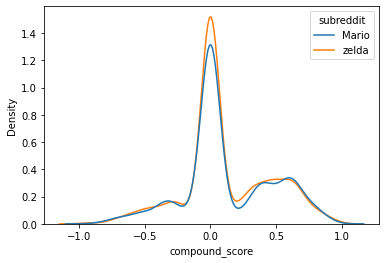

In [15]:
sns.kdeplot(data = df, x= "compound_score", hue = "subreddit");

Most of the post are neutral for both reddit threads. Mario have a slightly higher average sentiment score compared to zelda.

### For Simplicity of the model: We would focus only on the title column of the dataframe. 

In [16]:
df = df[["subreddit","target","title"]]

In [17]:
df.sample(5)

,subreddit,target,title
224,Mario,1,What are your guy’s thoughts on the new Mario ...
3759,zelda,0,[SS] [TotK] This scene in the Skies is so monu...
2501,zelda,0,[TP] Does anyone know any sellers on eBay that...
4337,zelda,0,[ALL] New Console? Odd Timing. My Bet
1308,Mario,1,im simultaneously excited and scared


### WordCloud Visualisation of Common Word in Mario and Zelda

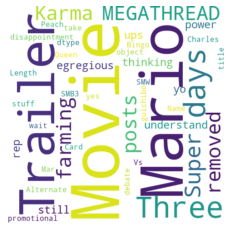

In [18]:
# Create a list of word
text= mario['title']

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, 
                      background_color='white').generate(str(text))

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

There is significant interested on the upcoming "Mario Movie". This is out of the scope for this analysis. Hence, we would remove word relating to the movie.

### Most Common Words for Mario Subreddit

In [19]:
cvec = CountVectorizer(stop_words="english")
cvec.fit(mario['title'])

CountVectorizer(stop_words='english')

In [20]:
# Transforming using our fitted cvec and converting the result to a DataFrame
mario_words = pd.DataFrame(cvec.transform(mario['title']).todense(),
                       columns=cvec.get_feature_names_out())

In [21]:
# Finding the top 100 words that frequently appeared in mario subreddits
mario_top = mario_words.sum(axis = 0).sort_values(ascending = False).head(100)
mario_top

mario       989
movie       575
trailer     210
super       189
like        135
           ... 
love         18
wait         18
actually     18
daisy        18
ll           18
Length: 100, dtype: int64

In [22]:
# Name of Top 100 most frequent Features/Columns
mario_pd = pd.DataFrame(data=mario_top)
mario_pd.index

Index(['mario', 'movie', 'trailer', 'super', 'like', 'bowser', 'pratt',
       'voice', 'chris', 'bros', 'just', 'new', 'think', 'good', 'look',
       'poster', 'toad', 'did', 'know', 'guys', 'sonic', 'don', 'peach',
       'looks', 'luigi', 'meme', 'nintendo', 've', 'game', 'people', 'time',
       'really', 'amp', 'day', 'black', 'does', 'gonna', 'jack', 'world', '64',
       'art', 'penguins', 'make', 'scene', 'character', 'thought', 'design',
       'yield', 'stop', 'characters', 'sounds', 'real', 'favorite', 'games',
       'oc', 'fan', 'bad', 'fans', 'way', 'looking', 'pretty', 'right',
       'great', 'better', 'saw', 'brooklyn', 'thoughts', 'original', 'hard',
       'illumination', 'theory', 'princess', 'best', 'want', 'kart', 'bingo',
       'got', 'film', 'days', 'yoshi', 'official', 'getting', 'let', 'hope',
       'thing', 'villain', 'mushroom', 'charles', 'vs', 'power', 'fanart',
       'martinet', 'need', 'drawing', 'say', 'love', 'wait', 'actually',
       'daisy', 'll

In [23]:
mario_top = mario_words[mario_pd.index]
mario_top.head()

,mario,movie,trailer,super,like,bowser,pratt,voice,chris,bros,...,fanart,martinet,need,drawing,say,love,wait,actually,daisy,ll
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0


In [24]:
# Which words appear the most in Mario subreddits?
word_counts = mario_words.sum(axis=0)
print("Most common words in Mario Subreddits")
word_counts.sort_values(ascending = False).head(20)

Most common words in Mario Subreddits


mario      989
movie      575
trailer    210
super      189
like       135
bowser     122
pratt      115
voice      110
chris      110
bros       106
just        97
new         93
think       77
good        70
look        66
poster      66
toad        62
did         60
know        59
guys        58
dtype: int64

In [25]:
mario_top_20 = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])

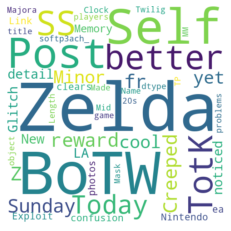

In [26]:
# Create a list of word
text= zelda['title']

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, 
                      background_color='white').generate(str(text))

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

There is significant mention of the characters' name and game title. This could be considered "cheat words" as it is irrelevant to find the characteristic of players.

### Most Common Words for Zelda Subreddit

In [27]:
cvec = CountVectorizer(stop_words="english")
cvec.fit(zelda['title'])

CountVectorizer(stop_words='english')

In [28]:
# Transforming using our fitted cvec and converting the result to a DataFrame
zelda_words = pd.DataFrame(cvec.transform(zelda['title']).todense(),
                       columns=cvec.get_feature_names_out())

In [29]:
# Finding the top 100 words that frequently appeared in data science subreddits
zelda_top = zelda_words.sum(axis = 0).sort_values(ascending = False).head(100)
zelda_top

botw         587
zelda        503
totk         451
oc           437
link         335
            ... 
cosplay       23
edition       23
beat          22
character     22
little        22
Length: 100, dtype: int64

In [30]:
# Name of Top 100 most frequent Features/Columns
zelda_pd = pd.DataFrame(data=zelda_top)
zelda_pd.index

Index(['botw', 'zelda', 'totk', 'oc', 'link', 'oot', 'game', 'tp', 'mm', 'art',
       'ss', 'time', 'just', 'tears', 'loz', 'kingdom', 'ww', 'games', 'sword',
       'like', 'princess', 'best', 'think', 'got', 'new', 'hyrule', 'twilight',
       'mask', 'legend', 'wild', 'linktober', 'trailer', 'did', 'day',
       'breath', 'majora', 'nintendo', 'favorite', 've', 'playing', 'series',
       'today', 'la', 'ocarina', 'play', 'finished', 'drew', 'years', 'theory',
       'skyward', 'switch', 'know', 'finally', 'guys', 'make', 'wind', 'love',
       'does', 'way', '3d', 'fanart', 'tried', 'temple', 'version', 'waker',
       'master', 'mc', 'discussion', 'ganondorf', 'getting', 'timeline',
       'feel', 'spirit', 'want', 'music', 'need', 'good', 'boss', 'cover',
       'tattoo', 'worth', 'used', 'title', 'help', 'played', 'great', 'really',
       'alttp', 'post', 'figure', 'old', 'custom', 'midna', 'design', 'hope',
       'cosplay', 'edition', 'beat', 'character', 'little'],
      dt

In [31]:
zelda_top = zelda_words[zelda_pd.index]
zelda_top.head()

,botw,zelda,totk,oc,link,oot,game,tp,mm,art,...,old,custom,midna,design,hope,cosplay,edition,beat,character,little
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Which words appear the most in Zelda subreddits?
word_counts = zelda_words.sum(axis=0)
print("Most common words in Zelda Subreddits")
word_counts.sort_values(ascending = False).head(20)

Most common words in Zelda Subreddits


botw       587
zelda      503
totk       451
oc         437
link       335
oot        280
game       206
tp         179
mm         152
art        130
ss         128
time       124
just       109
tears      106
loz         99
kingdom     99
ww          89
games       88
sword       86
like        80
dtype: int64

In [33]:
zelda_top_20 = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])

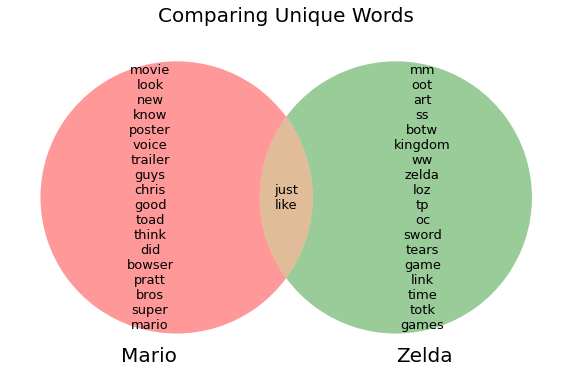

In [34]:
plt.figure(figsize=(10,10))
plt.title('Comparing Unique Words',fontsize=20)

set_a = set(mario_top_20.index)
set_b = set(zelda_top_20.index)

venn = venn2([set_a,set_b],set_labels=['Mario','Zelda'])
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

## Data Cleaning

**Set Tokenizer**

In [35]:
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

In [36]:
lemmatizer = WordNetLemmatizer()

**Create function that takes a column containing text and returns the lemmatized version in a new 'cleaned' column**

In [37]:
def column_cleaner(column, df=df):   
    #for loop through each row in the column:
    for i in range(len(df[column])):
        
        #Tokenize, or separate, each word in column's string into its own string (prep for lemmatization):
        col_tok = []
        col_tok.extend(tokenizer.tokenize(df[column][i].lower()))
        col_token = []
        [col_token.append(s) for s in col_tok if s not in col_token]
        
        #Lemmatize the words (cut the word to its base/root, for improved model results):
        col_lem = []
        for x in range(len(col_token)):
            col_lem.append(lemmatizer.lemmatize(col_token[x]))
        
        #Remove characters and numbers (for improved model results, hopefully):
        letters_only_col = []
        for c in range(len(col_lem)):
            letters_only_col.append(re.sub("[^a-zA-Z]", "", col_lem[c]))
        
        #Remove stopwords (for improved model results):
        col_words = [w for w in letters_only_col if not w in stopwords.words('english')]
        
        #Remove 'cheat' words (words that are in the subreddit's name and also in the column)
        # Remove characters' name and game title
                       # Mario cheatwords
        cheat_words = ['mario', 'party', 'marioparty', 'smash', 'bros', 'browser',
                       'ultimate', 'smashbrosultimate', 'super', 'superstar',
                       'luigi', 'peach', 'toad', 'bowser', 'game', 'ss', 'waluigi',
                       'daisy', 'yoshi', 'donkey', 'king boo', 'kong','diddy', 
                       'rosalina', 'toadette','toadsworth', 'captain', 'poochy',
                       'birdo', 'pauline', 'kamek', 'kammy', 'koopa', 'jr',
                       'wario', 'fawful', 'kart', 'paper', 'kart', 'sonic', 'dr.',
                       
                       # Zelda cheatwords
                       "zelda", "princess", "link","botw", "totk", "oc", "oot",
                       'majora', 'mask', 'ocarina', 'time', "mm", "hyrule", "tp",
                       'ganon', 'darklink','nightmares','twinrova','vaati',
                       'zant', 'demise', 'yuga', 'kohga', 'master', 'twilight',
                       'tears', 'kingdom', 'wind', 'waker', 'phantom', 'hourglass',
                       'legend', 'awakening', 'adventure', 'skyward', 'sword',
                       'tri',  'force', 'heroes', 'ww', 'breath', 'wild',
                       
                       # Mario Movie
                       "movie", "trailer", "chris", "pratt", "voice", "poster",
                       "sequel", "remade", "charles", "martinet", "charlie",
                       "anya", "jack", "black", "actor", "live", "action",
                       "netflix", "live", "action", "cast"] 
        col_words = [w for w in letters_only_col if not w in cheat_words]
        
        #Ensure that there are no 'None' objects in title_words:
        col_words = list(filter(None, col_words))

        #Join the lemmatized words - stopwords back to one long string (prep for
        #vectorization, done outside/after this function):
        col_words = " ".join(col_words)

        #Fill new column with 'cleaned' string from column:
        df.loc[i,(column+'_clean')] = col_words

In [38]:
df

,subreddit,target,title
0,Mario,1,Super Mario Movie Trailer MEGATHREAD
1,Mario,1,"Karma farming posts get removed, egregious rep..."
2,Mario,1,"If there are power ups in the movie, how do yo..."
3,Mario,1,I'm still thinking about the Mario Movie so I ...
4,Mario,1,I understand the disappointment of Charles Mar...
...,...,...,...
4705,zelda,0,[TotK] Nintendo clears up confusion over Zelda...
4706,zelda,0,[BoTW] [TotK] Zelda and Link. (By @softp3ach_)
4707,zelda,0,[TP] [SS] - Which Zelda game is better? Twilig...
4708,zelda,0,[BoTW] Mid 20s problems for Zelda players


In [39]:
column_cleaner(column='title', df=df)

**Save version of DataFrame**

In [40]:
df.to_csv('master_df_cleaned.csv', index=False, sep=",")

In [41]:
df.head(3)

,subreddit,target,title,title_clean
0,Mario,1,Super Mario Movie Trailer MEGATHREAD,megathread
1,Mario,1,"Karma farming posts get removed, egregious rep...",karma farming post get removed egregious repos...
2,Mario,1,"If there are power ups in the movie, how do yo...",if there are power ups in the how do you think...


In [42]:
df.sample(3)

,subreddit,target,title,title_clean
4374,zelda,0,[SS] opinions? Worth it???,opinion worth it
130,Mario,1,biblically accurate Mario,biblically accurate
3815,zelda,0,[TOTK] Trailer Language - Lettering,language lettering


## Data Visualization

### Top 25 word for Mario Game

In [43]:
def nplot(subreddit,column):
    fig,ax = plt.subplots(1,3, figsize=(15,6))
    fig.suptitle("Top 25 Most Common Words of " + subreddit, fontsize=20)
    geb={} # Collet top 25 word of each n-gram

    for i in range(1,4): # common bigram trigram quadgram
        word = []
    
        cvec = CountVectorizer(ngram_range=(i,i), stop_words="english")
        text_cvec = cvec.fit_transform(df[df['subreddit']== subreddit ][column])
    
        vec = pd.DataFrame(text_cvec.toarray(),columns= cvec.get_feature_names_out())
        word.append(vec.sum().sort_values(ascending=False)[:25].index)
        geb[i] = list(word[0])
        ax[i-1].barh(vec.sum().sort_values(ascending=False)[:25][::-1].index,
                 vec.sum().sort_values(ascending=False)[:25][::-1])
        ax[i-1].set_xlabel("number of word")
        ax[i-1].set_ylabel("word important")
        ax[i-1].set_title(f" {i}-grams")
        plt.tight_layout();

    
    print(f"Word Important of each n_gram:")
    for x, y in geb.items():
        print(f"word {x}-gram", y)
        print("------------------------------------------------------------------------------------")

Word Important of each n_gram:
word 1-gram ['mario', 'movie', 'trailer', 'super', 'like', 'bowser', 'pratt', 'voice', 'chris', 'bros', 'just', 'new', 'think', 'good', 'look', 'poster', 'toad', 'did', 'know', 'guys', 'sonic', 'don', 'peach', 'looks', 'luigi']
------------------------------------------------------------------------------------
word 2-gram ['mario movie', 'super mario', 'chris pratt', 'mario bros', 'movie trailer', 'bros movie', 'movie poster', 'mario voice', 'jack black', 'new mario', 'mario 64', 'mario amp', 'look like', 'looks like', 'pratt mario', 'voice mario', 'princess peach', 'don know', 'amp sonic', 'mario kart', 'gonna stop', 'charles martinet', 'mario trailer', 'guys think', 'meme template']
------------------------------------------------------------------------------------
word 3-gram ['super mario bros', 'mario bros movie', 'mario movie trailer', 'super mario movie', 'new mario movie', 'chris pratt mario', 'mario movie poster', 'mario amp sonic', 'super mari

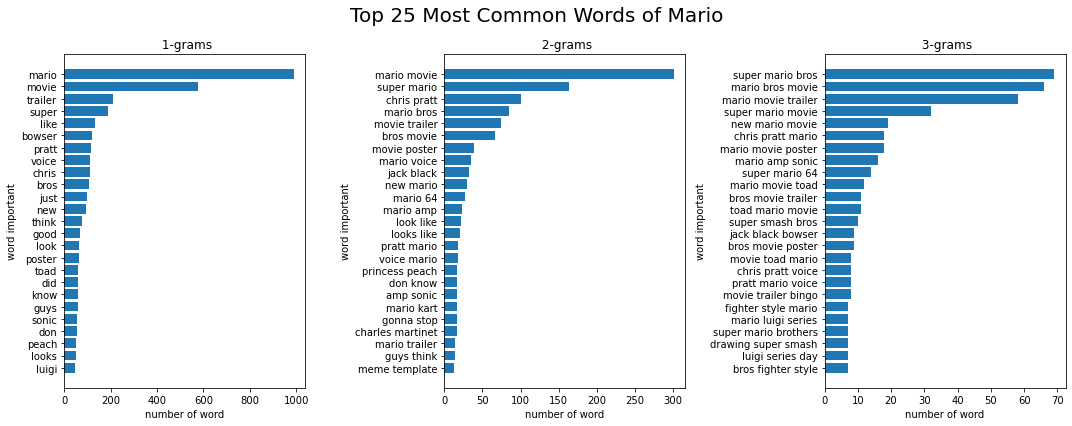

In [44]:
nplot("Mario","title")

Word Important of each n_gram:
word 1-gram ['like', 'look', 'just', 'new', 'think', 'wa', 'good', 'guy', 'know', 'meme', 'character', 'day', 'don', 'ha', 'did', 'thought', 'nintendo', 'fan', 'people', 'penguin', 've', 'design', 'make', 'really', 'world']
------------------------------------------------------------------------------------
word 2-gram ['look like', 'don know', 'gonna stop', 'guy think', 'meme template', 'wa good', 'brooklyn accent', 'don think', 'design look', 'bingo card', 'danny devito', 'look great', 'feel like', 'think look', 'people need', 'fix felix', 'drawing fighter', 'nintendo switch', 'really need', 'fighter style', 'new design', 'style series', 'just doe', 'spark hope', 'character like']
------------------------------------------------------------------------------------
word 3-gram ['style series day', 'fighter style series', 'design look like', 'drawing fighter style', 'amp gentleman fan', 'gentleman fan alike', 'actually sound good', 'rabbids spark hope', '

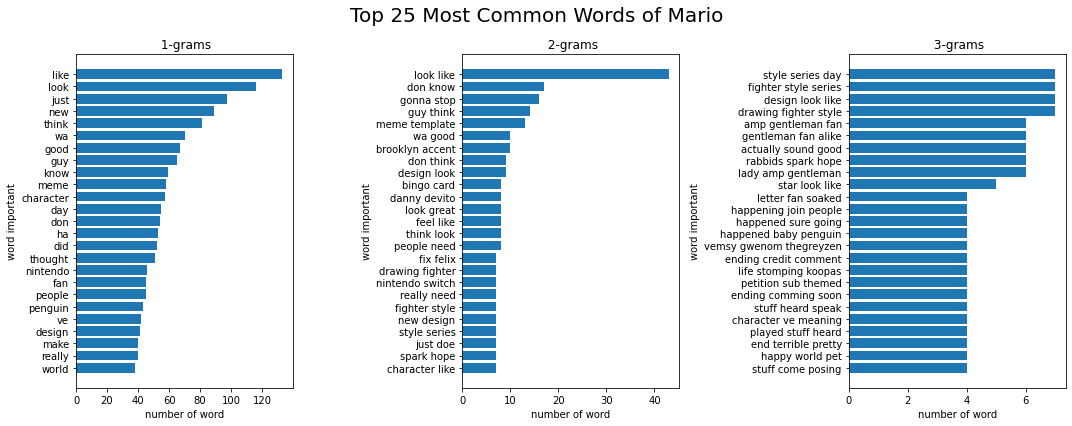

In [45]:
# Remove character names, game titles and movie related.
nplot("Mario","title_clean")

Mario reddit are more focus on the looks of characters and meme. Moreover, there a considerable numbers of design and fan for the franchise.

### Top 25 word for Zelda Game

Word Important of each n_gram:
word 1-gram ['botw', 'zelda', 'totk', 'oc', 'link', 'oot', 'game', 'tp', 'mm', 'art', 'ss', 'time', 'just', 'tears', 'loz', 'kingdom', 'ww', 'games', 'sword', 'like', 'princess', 'best', 'think', 'got', 'new']
------------------------------------------------------------------------------------
word 2-gram ['tears kingdom', 'zelda game', 'twilight princess', 'breath wild', 'legend zelda', 'majora mask', 'ocarina time', 'skyward sword', 'botw totk', 'botw oc', 'zelda link', 'wind waker', 'oot mm', 'oc botw', 'oc oot', 'zelda games', 'tp twilight', 'botw zelda', 'totk oc', 'botw link', 'oot oc', 'master sword', 'oc tp', 'zelda tears', 'need help']
------------------------------------------------------------------------------------
word 3-gram ['zelda tears kingdom', 'tp twilight princess', 'mm majora mask', 'botw breath wild', 'tears kingdom trailer', 'totk tears kingdom', 'ss skyward sword', 'tp wolf link', 'zelda breath wild', 'legend zelda tears', 'oc tot

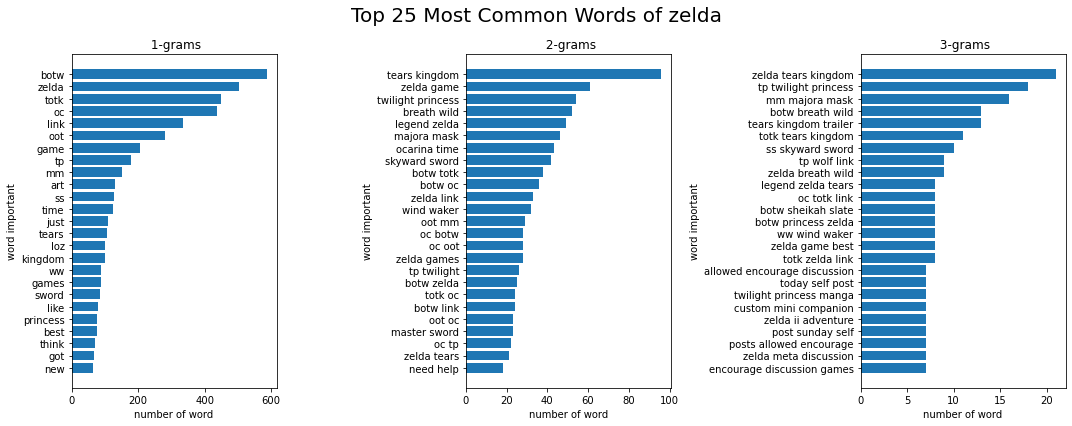

In [46]:
nplot("zelda","title")

Word Important of each n_gram:
word 1-gram ['art', 'just', 'tear', 'loz', 'like', 'best', 'wa', 'think', 'got', 'day', 'new', 'year', 'linktober', 'make', 'did', 'guy', 'ha', 'play', 'nintendo', 'playing', 'favorite', 'series', 'drew', 'la', 'today']
------------------------------------------------------------------------------------
word 2-gram ['linktober day', 'need help', 'ha best', 'final bos', 'look like', 'fan art', 'thought share', 'spirit track', 've played', 'guy like', 'doe know', 'low poly', 'guy think', 'just finished', 'just got', 'mc minish', 'art style', 'mysterious figure', 'didn know', 'sheikah slate', 'best story', 've finished', 'best way', 'hope guy', 'gerudo valley']
------------------------------------------------------------------------------------
word 3-gram ['ha best story', 'posts allowed encourage', 'custom mini companion', 'wa lot work', 'today self post', 'self post sunday', 'meta discussion rule', 'sunday posts allowed', 'post sunday posts', 'allowed enc

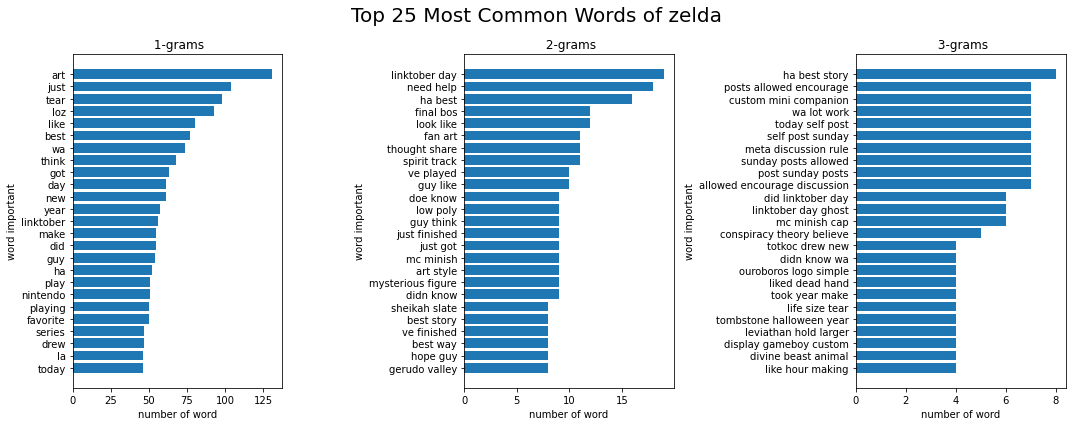

In [47]:
# Remove character names and game titles.
nplot("zelda","title_clean")

Zelda reddit are more focus on the art with community led event of [linktober](https://www.linktober.com/). Moreover, there a considerable numbers of discussion on gameplay specific topics such as boss event, seasonal event and story.

### Most Common Words for Mario Subreddit

In [48]:
cvec = CountVectorizer(stop_words="english")
cvec.fit(df[df["subreddit"] == "Mario"]["title_clean"])

CountVectorizer(stop_words='english')

In [49]:
# Transforming using our fitted cvec and converting the result to a DataFrame
mario_words = pd.DataFrame(cvec.transform(df[df["subreddit"] == "Mario"]["title_clean"]).todense(),
                       columns=cvec.get_feature_names_out())

In [50]:
# Finding the top 100 words that frequently appeared in mario subreddits
mario_top = mario_words.sum(axis = 0).sort_values(ascending = False).head(100)
mario_top

like         133
look         116
just          97
new           89
think         81
            ... 
bit           14
play          14
man           14
big           14
different     14
Length: 100, dtype: int64

In [51]:
# Name of Top 100 most frequent Features/Columns
mario_pd = pd.DataFrame(data=mario_top)
mario_pd.index

Index(['like', 'look', 'just', 'new', 'think', 'wa', 'good', 'guy', 'know',
       'meme', 'character', 'day', 'don', 'ha', 'did', 'thought', 'nintendo',
       'fan', 'people', 'penguin', 've', 'design', 'make', 'really', 'world',
       'gonna', 'doe', 'art', 'sound', 'scene', 'stop', 'yield', 'say', 'amp',
       'looking', 'bad', 'way', 'real', 'let', 'saw', 'right', 'favorite',
       'pretty', 'better', 'illumination', 'hope', 'hard', 'great', 'brooklyn',
       'want', 'best', 'villain', 'bingo', 'star', 'got', 'film', 'mushroom',
       'fanart', 'official', 'love', 'mean', 'getting', 'power', 'post',
       'drawing', 'need', 'year', 'come', 'style', 'theory', 'original',
       'credit', 'wait', 'actually', 'll', 'opinion', 'thing', 'brother',
       'plot', 'face', 'king', 'finally', 'accent', 'tell', 'series', 'feel',
       'happened', 'image', 'leaked', 'excited', 'title', 'ai', 'teaser', 'th',
       'going', 'bit', 'play', 'man', 'big', 'different'],
      dtype='object

In [52]:
mario_top = mario_words[mario_pd.index]
mario_top.head()

,like,look,just,new,think,wa,good,guy,know,meme,...,title,ai,teaser,th,going,bit,play,man,big,different
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Which words appear the most in Mario subreddits?
word_counts = mario_words.sum(axis=0)
print("Most common words in Mario Subreddits")
word_counts.sort_values(ascending = False).head(20)

Most common words in Mario Subreddits


like         133
look         116
just          97
new           89
think         81
wa            70
good          67
guy           65
know          59
meme          58
character     57
day           55
don           54
ha            53
did           52
thought       51
nintendo      46
fan           45
people        45
penguin       43
dtype: int64

In [54]:
mario_top_20 = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])

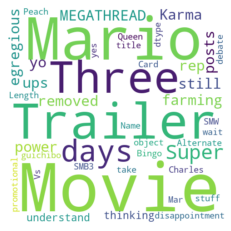

In [55]:
# Create a list of word
text= mario['title']

# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, 
                      background_color='white').generate(str(text))

# Display the generated image:
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

There is significant mention of the characters' name and game title. This could be considered "cheat words" as it is irrelevant to find the characteristic of players.

### Most Common Words for Zelda Subreddit

In [56]:
cvec = CountVectorizer(stop_words="english")
cvec.fit(df[df["subreddit"] == "zelda"]["title_clean"])

CountVectorizer(stop_words='english')

In [57]:
# Transforming using our fitted cvec and converting the result to a DataFrame
zelda_words = pd.DataFrame(cvec.transform(df[df["subreddit"] == "zelda"]["title_clean"]).todense(),
                       columns=cvec.get_feature_names_out())

In [58]:
# Finding the top 100 words that frequently appeared in data science subreddits
zelda_top = zelda_words.sum(axis = 0).sort_values(ascending = False).head(100)
zelda_top

art       131
just      104
tear       98
loz        93
like       80
         ... 
manga      20
ai         19
month      19
pretty     19
st         19
Length: 100, dtype: int64

In [59]:
# Name of Top 100 most frequent Features/Columns
zelda_pd = pd.DataFrame(data=zelda_top)
zelda_pd.index

Index(['art', 'just', 'tear', 'loz', 'like', 'best', 'wa', 'think', 'got',
       'day', 'new', 'year', 'linktober', 'make', 'did', 'guy', 'ha', 'play',
       'nintendo', 'playing', 'favorite', 'series', 'drew', 'la', 'today',
       'finished', 've', 'way', 'theory', 'know', 'love', 'switch', 'doe',
       'finally', 'version', 'fanart', 'tried', 'tattoo', 'look', 'need',
       'timeline', 'want', 'title', 'design', 'drawing', 'feel', 'ganondorf',
       'character', 'getting', 'discussion', 'temple', 'spirit', 'good',
       'thing', 'hero', 'mc', 'figure', 'used', 'world', 'alttp', 'great',
       'fan', 'really', 'post', 'lot', 'help', 'theme', 'midna', 'old', 'song',
       'custom', 'style', 'friend', 'edition', 'music', 'worth', 'bos', 'hope',
       'cosplay', 'inspired', 'korok', 'little', 'played', 'thought', 'cover',
       'piece', 'wii', 'themed', 'concept', 'isn', 'recently', 'dungeon',
       'opinion', 'island', 'beat', 'manga', 'ai', 'month', 'pretty', 'st'],
      d

In [60]:
zelda_top = zelda_words[zelda_pd.index]
zelda_top.head()

,art,just,tear,loz,like,best,wa,think,got,day,...,recently,dungeon,opinion,island,beat,manga,ai,month,pretty,st
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# Which words appear the most in Zelda subreddits?
word_counts = zelda_words.sum(axis=0)
print("Most common words in Zelda Subreddits")
word_counts.sort_values(ascending = False).head(20)

Most common words in Zelda Subreddits


art          131
just         104
tear          98
loz           93
like          80
best          77
wa            74
think         68
got           63
day           61
new           61
year          57
linktober     56
make          55
did           55
guy           54
ha            52
play          51
nintendo      51
playing       50
dtype: int64

In [62]:
zelda_top_20 = pd.DataFrame(word_counts.sort_values(ascending = False).head(20), columns=['count'])

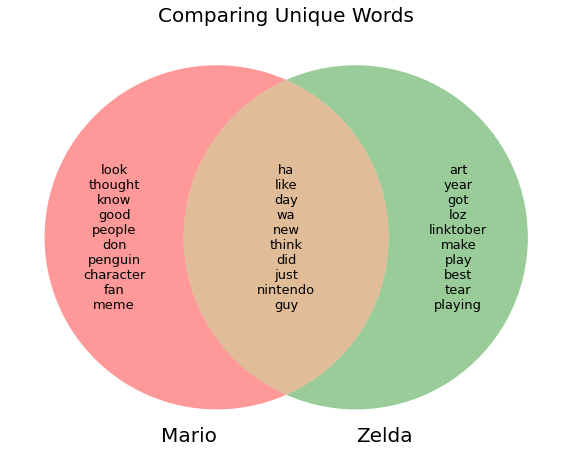

In [63]:
plt.figure(figsize=(10,10))
plt.title('Comparing Unique Words',fontsize=20)

set_a = set(mario_top_20.index)
set_b = set(zelda_top_20.index)

venn = venn2([set_a,set_b],set_labels=['Mario','Zelda'])
venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

## Modelling

### Naive Bayes -  MultinomialNB

The Naive Bayes classification algorithm is a classification modelling technique that relies on Bayes Theorem and assumes that our features are independent of one another. The advantage of making such an assumption is that it makes it easier to calcualte probabilities but it is incredibly unrealistic especially in the case of text data. While our classiciations might be accurate, our predicted probabilities will usually be inaccurate. In particular, we will be using the `MultinomialNB` model in this case.

### Messy Title Model

In [64]:
X = df["title"]
y = df["target"]

In [65]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

In [66]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3768,) (942,) (3768,) (942,)


In [67]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ("cvec", CountVectorizer()), # Transformer (fit, transform)
    ("nb", MultinomialNB()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

In [68]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 500, 1000, 1500, 2000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Check Stop_words: None or English.

pipe_params = {
    "cvec__max_features":[500,1000,1500,2000],
    "cvec__min_df": [2,3],
    "cvec__max_df": [0.9,0.95],
    "cvec__ngram_range": [(1,1),(1,2)],
    "cvec__stop_words": [None,"english"]
}

# ngram_range of (1,1) just returns individual tokens
# ngram_range of (1,2) just returns individual tokens AND bi-grams

In [69]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [70]:
# Fit GridSearch to training data.
start_time = time.time()
gs.fit(X_train,y_train)
print(f"Runtime:{time.time()-start_time}")

Runtime:21.275861501693726


In [71]:
# What's the best score?
gs.best_score_

0.9673553355103017

In [72]:
# What's the best params?
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [73]:
# Score model on training set.
# What is the score on a classifier? Accuracy
gs.score(X_train,y_train)

0.9803609341825902

In [74]:
# Score model on testing set.
gs.score(X_test,y_test)

0.9543524416135881

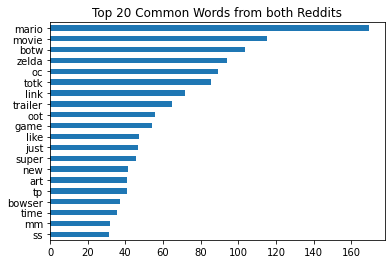

In [75]:
# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words="english")

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())
# Plot top 20 occuring words
X_train_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.title("Top 20 Common Words from both Reddits");

Mario's character is mentioned more often than Zelda's. This is likely due to the movie as the release of the trailer for the new video game movie. The attention is mostly negative as the internet usually reacts. This is not beneficial to our analysis of video games. Hence, it would be removed.

## Cleaned Title Model (Remove "Cheat words")

In [76]:
X = df["title_clean"]
y = df["target"]

In [77]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

In [78]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3768,) (942,) (3768,) (942,)


In [79]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ("cvec", CountVectorizer()), # Transformer (fit, transform)
    ("nb", MultinomialNB()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

In [80]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 500, 1000, 1500, 2000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).
# Check Stop_words: None or English.

pipe_params = {
    "cvec__max_features":[500,1000,1500,2000],
    "cvec__min_df": [2,3],
    "cvec__max_df": [0.9,0.95],
    "cvec__ngram_range": [(1,1),(1,2)],
    "cvec__stop_words": [None,"english"]
}

# ngram_range of (1,1) just returns individual tokens
# ngram_range of (1,2) just returns individual tokens AND bi-grams

In [81]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [82]:
# Fit GridSearch to training data.
start_time = time.time()
gs.fit(X_train,y_train)
print(f"Runtime:{time.time()-start_time}")

Runtime:16.743058443069458


In [83]:
# What's the best score?
gs.best_score_

0.8524434534188622

In [84]:
# What's the best params?
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [85]:
# Score model on training set.
# What is the score on a classifier? Accuracy
gs.score(X_train,y_train)

0.9179936305732485

In [86]:
# Score model on testing set.
gs.score(X_test,y_test)

0.8450106157112527

In [87]:
# Define score model dataframe for comparison
list_of_rows = []
score_df = pd.DataFrame()

def modelscore(gsmodel,transformer,model,cheatword):
    s = pd.Series({"Transformer": transformer, #"CountVectorizer","Tfid" 
               "Model" : model, #"MultinomialNB","Logistic"
               "Cheat Word" : cheatword , #"Included" , "Excluded"
               "Train Score" : gsmodel.score(X_train,y_train),
               "Test Score" : gsmodel.score(X_test,y_test)
               })
    list_of_rows.append(s) 
    global score_df
    score_df = pd.DataFrame(list_of_rows)
    print(score_df)

In [88]:
modelscore(gs, "CountVectorizer", "MultinomialNB", "Excluded")

       Transformer          Model Cheat Word  Train Score  Test Score
0  CountVectorizer  MultinomialNB   Excluded     0.917994    0.845011


In [89]:
score_df.head()

,Transformer,Model,Cheat Word,Train Score,Test Score
0,CountVectorizer,MultinomialNB,Excluded,0.917994,0.845011


In [90]:
# Let's set a pipeline up with two stages:
# 1. TfidfVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_tvec = Pipeline([
    ("tvec", TfidfVectorizer()), # Transformer (fit, transform)
    ("nb", MultinomialNB()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

In [91]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 500, 1000, 1500, 2000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {"tvec__max_features" : [500,1000,1500,2000],
                    "tvec__min_df": [2,3],
                    "tvec__max_df": [0.9,0.95],
                    "tvec__stop_words" : [None, "english"],
                    "tvec__ngram_range" : [(1,1),(1,2)]
                  }
    

In [92]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(estimator=pipe_tvec,
                      param_grid=pipe_tvec_params,
                      cv=5)

In [93]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [500, 1000, 1500, 2000],
                         'tvec__min_df': [2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [94]:
gs_tvec.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 2000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [95]:
# Score model on training set.
gs_tvec.score(X_train,y_train)

0.9267515923566879

In [96]:
# Score model on testing set.
gs_tvec.score(X_test,y_test)

0.8460721868365181

In [97]:
modelscore(gs_tvec, "TfidfVectorizer", "MultinomialNB", "Excluded")

       Transformer          Model Cheat Word  Train Score  Test Score
0  CountVectorizer  MultinomialNB   Excluded     0.917994    0.845011
1  TfidfVectorizer  MultinomialNB   Excluded     0.926752    0.846072


## Logistic Regression Models

Logistic regression is the most common binary classification algorithm. It will predict continuous probabilities between 0 and 1

In [98]:
# Let's set a pipeline up with two stages:
# 1. CountfVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_cvec_log = Pipeline([
    ("cvec", CountVectorizer()), # Transformer (fit, transform)
    ("logreg", LogisticRegression()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

# Search over the following values of hyperparameters:
# Maximum number of features fit: 500, 1000, 1500, 2000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_log_params = {"cvec__max_features":[500, 1000, 1500, 2000],
                        "cvec__min_df": [2,3],
                        "cvec__max_df": [0.9,0.95],
                        "cvec__ngram_range": [(1,1),(1,2)],
                        "cvec__stop_words": [None,"english"],
                       }
    

# Instantiate GridSearchCV.
gs_cvec_log = GridSearchCV(estimator=pipe_cvec_log,
                      param_grid=pipe_cvec_log_params,
                      cv=5)

# Fit GridSearch to training data.
gs_cvec_log.fit(X_train,y_train)

# Check best parameter
print(gs_cvec_log.best_params_)

# Score model on training set.
gs_cvec_log.score(X_train,y_train)

# Score model on testing set.
gs_cvec_log.score(X_test,y_test)

# Prediction
y_preds_cvec_log = gs_cvec_log.predict(X_test)

# Probability 
pred_proba_cvec_log = gs_cvec_log.predict_proba(X_test)

# Save model score to score dataframe
modelscore(gs_cvec_log, "CountVectorizer", "Logistic", "Excluded")

{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}
       Transformer          Model Cheat Word  Train Score  Test Score
0  CountVectorizer  MultinomialNB   Excluded     0.917994    0.845011
1  TfidfVectorizer  MultinomialNB   Excluded     0.926752    0.846072
2  CountVectorizer       Logistic   Excluded     0.967887    0.907643


In [99]:
X_test.index

Int64Index([3130, 2844, 4296,  972,   78, 3091, 1604, 4079, 2676,  491,
            ...
            4068, 4188, 4523, 4593, 2832, 3397, 3318, 2259, 1656, 1938],
           dtype='int64', length=942)

In [100]:
# Let's set a pipeline up with two stages:
# 1. TfidVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe_tvec_log = Pipeline([
    ("tvec", TfidfVectorizer()), # Transformer (fit, transform)
    ("logreg", LogisticRegression()) # Estimator or model (fit, predict)    
])

# .predict() of MultinomialNB allows us to have a score to judge
# our hyperparameters combinations when GridSearching

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_log_params = {"tvec__max_features" : [2000,3000,4000,5000],
                        "tvec__min_df": [2,3],
                        "tvec__max_df": [0.9,0.95],
                        "tvec__stop_words" : [None, "english"],
                        "tvec__ngram_range" : [(1,1),(1,2)]
                       }
    

# Instantiate GridSearchCV.
gs_tvec_log = GridSearchCV(estimator=pipe_tvec_log,
                      param_grid=pipe_tvec_log_params,
                      cv=5)

# Fit GridSearch to training data.
gs_tvec_log.fit(X_train,y_train)

gs_tvec_log.best_params_

# Score model on training set.
gs_tvec_log.score(X_train,y_train)

# Score model on testing set.
gs_tvec_log.score(X_test,y_test)

# Prediction
y_preds_tvec_log = gs_tvec_log.predict(X_test)

# Probability 
pred_proba_tvec_log = gs_tvec_log.predict_proba(X_test)

# Save model score to score dataframe
modelscore(gs_tvec_log, "TfidfVectorizer", "Logistic", "Excluded")

       Transformer          Model Cheat Word  Train Score  Test Score
0  CountVectorizer  MultinomialNB   Excluded     0.917994    0.845011
1  TfidfVectorizer  MultinomialNB   Excluded     0.926752    0.846072
2  CountVectorizer       Logistic   Excluded     0.967887    0.907643
3  TfidfVectorizer       Logistic   Excluded     0.957272    0.892781


In [101]:
score_df

,Transformer,Model,Cheat Word,Train Score,Test Score
0,CountVectorizer,MultinomialNB,Excluded,0.917994,0.845011
1,TfidfVectorizer,MultinomialNB,Excluded,0.926752,0.846072
2,CountVectorizer,Logistic,Excluded,0.967887,0.907643
3,TfidfVectorizer,Logistic,Excluded,0.957272,0.892781


**Error Analysis**

In [102]:
df

,subreddit,target,title,title_clean
0,Mario,1,Super Mario Movie Trailer MEGATHREAD,megathread
1,Mario,1,"Karma farming posts get removed, egregious rep...",karma farming post get removed egregious repos...
2,Mario,1,"If there are power ups in the movie, how do yo...",if there are power ups in the how do you think...
3,Mario,1,I'm still thinking about the Mario Movie so I ...,i m still thinking about the so penguin scene ...
4,Mario,1,I understand the disappointment of Charles Mar...,i understand the disappointment of not voicing...
...,...,...,...,...
4705,zelda,0,[TotK] Nintendo clears up confusion over Zelda...,nintendo clear up confusion over tear of the s...
4706,zelda,0,[BoTW] [TotK] Zelda and Link. (By @softp3ach_),and by softpach
4707,zelda,0,[TP] [SS] - Which Zelda game is better? Twilig...,which is better for wii or
4708,zelda,0,[BoTW] Mid 20s problems for Zelda players,mid problem for player


In [103]:
# Instantiate Model
cvec = CountVectorizer(stop_words = "english")

'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None

In [104]:
# Fit
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [105]:
# Transform the corpus
X_train = cvec.transform(X_train)

In [106]:
train_df = pd.DataFrame(X_train.todense(), 
                        columns=cvec.get_feature_names_out())

In [107]:
train_df["target"] = y_train.values

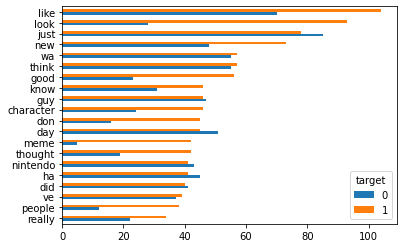

In [108]:
train_df.groupby('target').sum()\
.T.sort_values(1, ascending=True).tail(20).plot.barh();

## Evaluation 

Evaluation of the best model to

In [109]:
cm = confusion_matrix(y_test, y_preds_cvec_log)

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_cvec_log).ravel()

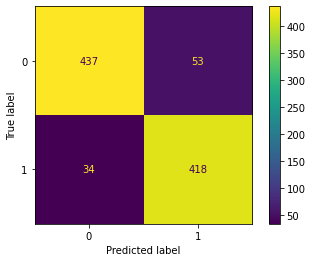

In [111]:
ConfusionMatrixDisplay(cm, display_labels=gs_tvec_log.classes_).plot();

In [112]:
fp

53

In [113]:
pred_proba_cvec_log

array([[0.71316487, 0.28683513],
       [0.59414195, 0.40585805],
       [0.69327566, 0.30672434],
       ...,
       [0.98986882, 0.01013118],
       [0.04570985, 0.95429015],
       [0.30112926, 0.69887074]])

In [114]:
pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

pred_df.head()

,true_values,pred_probs
3130,0,0.074456
2844,0,0.027340
4296,0,0.394553
972,1,0.999457
78,1,0.274863


In [115]:
test_df = pd.DataFrame(X_test)
test_df['actual_class'] = y_test
test_df['predict_class'] = y_preds_cvec_log
pred_proba = [i[0] for i in gs.predict_proba(X_test)]
test_df['probability'] = pred_proba

In [116]:
test_df

,title_clean,actual_class,predict_class,probability
3130,alttp i hate the freaking swamp palace,0,0,0.925544
2844,i accidently did the glitch while getting fish,0,0,0.972660
4296,some fanart by me always had my favorite desig...,0,0,0.605447
972,also some of the criticizers could be a little...,1,1,0.000543
78,the best or,1,1,0.725137
...,...,...,...,...
3397,wwoc doing linktober this year and today s pro...,0,0,1.000000
3318,by winterregalia,0,0,0.861393
2259,all which of these creeped you the most in,0,0,0.956870
1656,who s ready to ruin this for their kid,1,1,0.003627


In [117]:
false_df = test_df[test_df['actual_class'] != 
                   test_df['predict_class']]
false_df.head(10)

,title_clean,actual_class,predict_class,probability
4079,totka zelink fan animation the want some atten...,0,1,0.044652
3021,wwtp jeff grubb apologizes for mistaken port r...,0,1,0.881611
991,ay lakituman where s the fricking art by scott...,1,0,0.898454
4240,and we never saw it again,0,1,0.007468
1283,all right the title wa revealed let ago,1,0,0.680941
3109,what is the point in these stone i see them ev...,0,1,0.833215
663,my pitch for a spin off,1,0,0.701827
1343,corporate would like you to find the differenc...,1,0,0.899535
3845,to defeat for the fifth lol,0,1,0.080361
4139,and,0,1,0.586904


## Conclusion

- Mario's and Zelda's Reddit is quite different and easy to identify as the model can predict with an accuracy of over 90% after removing characters' names, game titles and movie-related words.
- Mario Reddit is more focused on the looks of characters and memes. Moreover, there are considerable numbers of designs and fans for the franchise.
- Zelda Reddit is more focused on art with the community-led event of the "linktober". Moreover, there are considerable discussions on gameplay-specific topics such as a boss event, seasonal event and story.


## Recommendation

- We should use more data from other social media platforms to better understand the difference between Mario and Zelda fans so that we could target advertising campaigns accordingly. 
- Additionally, gamers on different platforms tend to display a unique pattern of behaviour to fit in with the group.